<a href="https://colab.research.google.com/github/lorenafc/Capita_Selecta_RHI50403/blob/main/Maps_authors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cartopy -q
!pip install contextily -q
!pip install pyproj -q

In [ ]:
#import libraries
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
uploaded=files.upload()

In [ ]:
file_name = 'merged_additional_authors_encoded.xlsx'
authors_small_cities = pd.read_excel(file_name, engine='openpyxl')
authors_small_cities_copy=authors_small_cities.copy()
authors_small_cities_copy.head()

# Active Maps - Gif


used death place when active was not available

In [ ]:
## source: Lucas Koren and chatGPT

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as cx
import os
import imageio

# Convert the active city locations to a GeoDataFrame
authors_small_cities.rename(columns={'Unnamed: 0': 'indexauthor'}, inplace=True)
authors_small_cities['deathcity'] = authors_small_cities['deathcity'].fillna('Unknown')

# Create GeoSeries for death and active points
death_points = gpd.GeoSeries([Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None
                              for xy in zip(authors_small_cities['longitude_death'], authors_small_cities['latitude_death'])], crs="EPSG:4326")
active_points = gpd.GeoSeries([Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None
                               for xy in zip(authors_small_cities['longitude_active'], authors_small_cities['latitude_active'])], crs="EPSG:4326")

# Combine active and death points into a single GeoSeries, preferring active points when available
combined_points = active_points.fillna(death_points)

# Now create a GeoDataFrame using the combined geometry column
authors_small_cities_combined = gpd.GeoDataFrame(authors_small_cities, geometry=combined_points)
authors_small_cities_combined = authors_small_cities_combined[authors_small_cities_combined.geometry.notnull()]

# Set the CRS for the new GeoDataFrame
authors_small_cities_combined = authors_small_cities_combined.set_crs("EPSG:4326").to_crs(epsg=3857)

# Filter the DataFrame for the specified year range
authors_small_cities_combined = authors_small_cities_combined[
    (authors_small_cities_combined['deathyear'] >= 800) & (authors_small_cities_combined['deathyear'] <= 1800)
].copy()

# Define the start and end years
startyear = 800
endyear = 1800
step = 1
batch_size = 100  # Number of years to process in each batch

output_dir = "/content/drive/My Drive/capita_selecta/active_maps/"
os.makedirs(output_dir, exist_ok=True)

# Czech Republic boundaries in Web Mercator projection
world_bounds = [1345852.64, 6190443.81, 2170730.07, 6631028.36] # czech repub. boundaries

# Invisible points to ensure full basemap is displayed
invisible_points = gpd.GeoDataFrame({
    'geometry': [
        Point(-20037508.34, -20037508.34),  # Bottom left
        Point(20037508.34, -20037508.34),   # Bottom right
        Point(-20037508.34, 20037508.34),   # Top left
        Point(20037508.34, 20037508.34)     # Top right
    ],
    'point_count': [0, 0, 0, 0]
}, crs="EPSG:3857")

# Loop through the timesteps in batches
for batch_start in range(startyear, endyear, batch_size):
    batch_end = min(batch_start + batch_size, endyear)

    # Loop through the timesteps in the current batch
    for i, timestep in enumerate(range(batch_start - 1, batch_end, step)):
        # Create a string to represent the current timestep
        years = f"{timestep + 1}"

        # Filter the GeoDataFrame for authors active in the timestep
        authors_active_timestep = authors_small_cities_combined[
            (authors_small_cities_combined['deathyear'] > timestep) &
            (authors_small_cities_combined['deathyear'] <= timestep + step)
        ]

        # Check if there are any valid records for the current timestep
        if not authors_active_timestep.empty:
            # Group by unique points and get the count for each group and turn into geodataframe
            unique_points_gdf = gpd.GeoDataFrame(
                authors_active_timestep.groupby('geometry').size().reset_index(name='point_count'),
                geometry='geometry'
            )

            # Ensure the CRS is set to EPSG:3857 for latitude and longitude
            unique_points_gdf = unique_points_gdf.set_crs(epsg=3857, allow_override=True)

            # Add invisible points to ensure full basemap is displayed
            unique_points_gdf = pd.concat([unique_points_gdf, invisible_points], ignore_index=True)

            fig, ax = plt.subplots(figsize=(19, 10))

            # Plot the points with a fixed aspect ratio
            unique_points_gdf.plot(ax=ax, column='point_count', cmap='Reds', markersize=unique_points_gdf['point_count']*15, aspect=0.7) # Adjust markersize as needed

            # Add basemap with fixed zoom level
            cx.add_basemap(ax, attribution=False, zoom=5, crs=unique_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

            # Set plot limits to fixed geographic bounds
            ax.set_xlim(world_bounds[0], world_bounds[2])
            ax.set_ylim(world_bounds[1], world_bounds[3])

            # Set title and axis labels
            ax.set_title(f"Authors' Hotspots ({years})")
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            # Set tick labels to show the Mercator projection coordinates
            ax.set_xticks([-20037508.34, -16707925.61, -13358339.89, -10018754.17, -6679169.45, -3339584.72, 0, 3339584.72, 6679169.45, 10018754.17, 13358339.89, 16707925.61, 20037508.34])
            ax.set_xticklabels(['180° W', '150° W', '120° W', '90° W', '60° W', '30° W', '0', '30° E', '60° E', '90° E', '120° E', '150° E', '180° E'])

            ax.set_yticks([-6679169, -5009377, -3339584, -1669792, 0, 1669792, 3339584, 5009377, 6679169, 8826910.12, 10958014.95])
            ax.set_yticklabels(["60° S", "45° S", '30° S', "15° S", '0', "15° N", '30° N', "45° N", "60° N", "67.5° N", "75° N"])

            # Save plot as .png file
            plt.savefig(f"{output_dir}active_hotspot_plot_{years}.png")

            # Close the current figure to avoid overlapping plots
            plt.close(fig)

    active_files = os.listdir(output_dir)
    active_files_paths = [os.path.join(output_dir, active_file) for active_file in active_files if active_file.endswith('.png')]

    images = []
    for active_file in active_files_paths:
        images.append(imageio.imread(active_file))

    # Save the GIF with looping enabled
    gif_path = f'/content/drive/My Drive/capita_selecta/active_maps/authors_gif_ZOOM5_bound_czech_loopgif_{batch_start}_{batch_end}.gif'
    imageio.mimsave(gif_path, images, fps=10, format='GIF', loop=0)

# Combine all batch GIFs into a final GIF
final_gif_path = '/content/drive/My Drive/capita_selecta/active_maps/authors_movie_final_ZOOM_2_bound_mercator_loopgif_800_802_Reds_Voyager.gif'
batch_gif_paths = [f'/content/drive/My Drive/capita_selecta/active_maps/authors_movie_fixed_bounds_ZOOM1_bound_mercator_loopgif_{batch_start}_{batch_start + batch_size}.gif' for batch_start in range(startyear, endyear, batch_size)]




images = []
for batch_gif_path in batch_gif_paths:
    gif_images = imageio.mimread(batch_gif_path)
    images.extend(gif_images)

imageio.mimsave(final_gif_path, images, fps=50, format='GIF', loop=0)


/usr/local/lib/python3.10/dist-packages/geopandas/tools/hilbert_curve.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  res = (vals - val_range[0]) * (n / width)
/usr/local/lib/python3.10/dist-packages/geopandas/tools/hilbert_curve.py:106: RuntimeWarning: invalid value encountered in multiply
  res = (vals - val_range[0]) * (n / width)
/usr/local/lib/python3.10/dist-packages/geopandas/tools/hilbert_curve.py:109: RuntimeWarning: invalid value encountered in cast
  return res.astype(np.uint32)
/usr/local/lib/python3.10/dist-packages/geopandas/tools/hilbert_curve.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  res = (vals - val_range[0]) * (n / width)
/usr/local/lib/python3.10/dist-packages/geopandas/tools/hilbert_curve.py:106: RuntimeWarning: invalid value encountered in multiply
  res = (vals - val_range[0]) * (n / width)
/usr/local/lib/python3.10/dist-packages/geopandas/tools/hilbert_curve.py:109: RuntimeWarning: invalid value encountered in ca

In [ ]:
import imageio
import os

# Paths to individual batch GIFs
batch_gif_paths = [
    '/content/drive/My Drive/capita_selecta/active_maps/authors_movie_fixed_bounds_ZOOM1_bound_mercator_loopgif_800_900.gif',
    '/content/drive/My Drive/capita_selecta/active_maps/authors_movie_fixed_bounds_ZOOM1_bound_mercator_loopgif_901_1000.gif',
    '/content/drive/My Drive/capita_selecta/active_maps/authors_movie_fixed_bounds_ZOOM1_bound_mercator_loopgif_1001_1100.gif',
    '/content/drive/My Drive/capita_selecta/active_maps/authors_movie_fixed_bounds_ZOOM1_bound_mercator_loopgif_1101_1200.gif'
]

# Path to save the final combined GIF
final_gif_path = '/content/drive/My Drive/capita_selecta/active_maps/authors_movie_final_ZOOM_2_bound_mercator_loopgif_800_1200.gif'

# Read and concatenate frames from all batch GIFs
images = []
for batch_gif_path in batch_gif_paths:
    gif_images = imageio.mimread(batch_gif_path)
    images.extend(gif_images)

# Save the combined frames as a single GIF
imageio.mimsave(final_gif_path, images, fps=10, format='GIF', loop=0)

print(f"Final combined GIF saved at: {final_gif_path}")


In [ ]:
## ask chatgpt fix zoom czeck

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as cx
import os
import imageio

# Assuming 'authors_small_cities' is your DataFrame and it's already loaded

# Convert the active city locations to a GeoDataFrame
authors_small_cities.rename(columns={'Unnamed: 0': 'indexauthor'}, inplace=True)
authors_small_cities['deathcity'] = authors_small_cities['deathcity'].fillna('Unknown')

# Create GeoSeries for death and active points
death_points = gpd.GeoSeries([Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None
                              for xy in zip(authors_small_cities['longitude_death'], authors_small_cities['latitude_death'])], crs="EPSG:4326")
active_points = gpd.GeoSeries([Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None
                               for xy in zip(authors_small_cities['longitude_active'], authors_small_cities['latitude_active'])], crs="EPSG:4326")

# Combine active and death points into a single GeoSeries, preferring active points when available
combined_points = active_points.fillna(death_points)

# Now create a GeoDataFrame using the combined geometry column
authors_small_cities_combined = gpd.GeoDataFrame(authors_small_cities, geometry=combined_points)
authors_small_cities_combined = authors_small_cities_combined[authors_small_cities_combined.geometry.notnull()]

# Set the CRS for the new GeoDataFrame
authors_small_cities_combined = authors_small_cities_combined.set_crs("EPSG:4326").to_crs(epsg=3857)

# Filter the DataFrame for the specified year range
authors_small_cities_combined = authors_small_cities_combined[
    (authors_small_cities_combined['deathyear'] >= 800) & (authors_small_cities_combined['deathyear'] <= 1800)
].copy()

# Define the start and end years
startyear = 800
endyear = 802
step = 1
batch_size = 100  # Number of years to process in each batch

output_dir = "/content/drive/My Drive/capita_selecta/active_maps/"
os.makedirs(output_dir, exist_ok=True)

# Europe boundaries in Web Mercator projection (rough estimation including the Czech Republic)
world_bounds = [1345852.64, 6190443.81, 2170730.07, 6631028.36] # Czech Republic bounds approximation

# Invisible points to ensure full basemap is displayed
invisible_points = gpd.GeoDataFrame({
    'geometry': [
        Point(-20037508.34, -20037508.34),  # Bottom left
        Point(20037508.34, -20037508.34),   # Bottom right
        Point(-20037508.34, 20037508.34),   # Top left
        Point(20037508.34, 20037508.34)     # Top right
    ],
    'point_count': [0, 0, 0, 0]
}, crs="EPSG:3857")

# Loop through the timesteps in batches
for batch_start in range(startyear, endyear, batch_size):
    batch_end = min(batch_start + batch_size, endyear)

    # Loop through the timesteps in the current batch
    for i, timestep in enumerate(range(batch_start - 1, batch_end, step)):
        # Create a string to represent the current timestep
        years = f"{timestep + 1}"

        # Filter the GeoDataFrame for authors active in the timestep
        authors_active_timestep = authors_small_cities_combined[
            (authors_small_cities_combined['deathyear'] > timestep) &
            (authors_small_cities_combined['deathyear'] <= timestep + step)
        ]

        # Check if there are any valid records for the current timestep
        if not authors_active_timestep.empty:
            # Group by unique points and get the count for each group and turn into geodataframe
            unique_points_gdf = gpd.GeoDataFrame(
                authors_active_timestep.groupby('geometry').size().reset_index(name='point_count'),
                geometry='geometry'
            )

            # Ensure the CRS is set to EPSG:3857 for latitude and longitude
            unique_points_gdf = unique_points_gdf.set_crs(epsg=3857, allow_override=True)

            # Add invisible points to ensure full basemap is displayed
            unique_points_gdf = pd.concat([unique_points_gdf, invisible_points], ignore_index=True)

            fig, ax = plt.subplots(figsize=(19, 10))

            # Plot the points with a fixed aspect ratio
            unique_points_gdf.plot(ax=ax, column='point_count', cmap='Reds', markersize=unique_points_gdf['point_count']*15, aspect=0.7)  # Adjust markersize as needed

            # Add basemap with fixed zoom level
            cx.add_basemap(ax, attribution=False, zoom=5, crs=unique_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

            # Set plot limits to fixed geographic bounds
            ax.set_xlim(world_bounds[0], world_bounds[2])
            ax.set_ylim(world_bounds[1], world_bounds[3])

            # Set title and axis labels
            ax.set_title(f"Authors' Hotspots ({years})")
            ax.set_xlabel('Longitude (Mercator)')
            ax.set_ylabel('Latitude (Mercator)')

            # Save plot as .png file
            plt.savefig(f"{output_dir}active_hotspot_plot_{years}.png")

            # Close the current figure to avoid overlapping plots
            plt.close(fig)

    active_files = os.listdir(output_dir)
    active_files_paths = [os.path.join(output_dir, active_file) for active_file in active_files if active_file.endswith('.png')]

    images = []
    for active_file in active_files_paths:
        images.append(imageio.imread(active_file))

    # Save the GIF with looping enabled
    gif_path = f'/content/drive/My Drive/capita_selecta/active_maps/authors_gif_ZOOM5_bound_czech_loopgif_{batch_start}_{batch_end}.gif'
    imageio.mimsave(gif_path, images, fps=10, format='GIF', loop=0)

# Combine all batch GIFs into a final GIF
final_gif_path = '/content/drive/My Drive/capita_selecta/active_maps/authors_movie_final_ZOOM_2_bound_mercator_loopgif_800_802_Reds_Voyager.gif'
batch_gif_paths = [f'/content/drive/My Drive/capita_selecta/active_maps/authors_movie_fixed_bounds_ZOOM1_bound_mercator_loopgif_{batch_start}_{batch_start + batch_size}.gif' for batch_start in range(startyear, endyear, batch_size)]

images = []
for batch_gif_path in batch_gif_paths:
    gif_images = imageio.mimread(batch_gif_path)
    images.extend(gif_images)

imageio.mimsave(final_gif_path, images, fps=50, format='GIF', loop=0)


# Birth Death Map - 800-1800

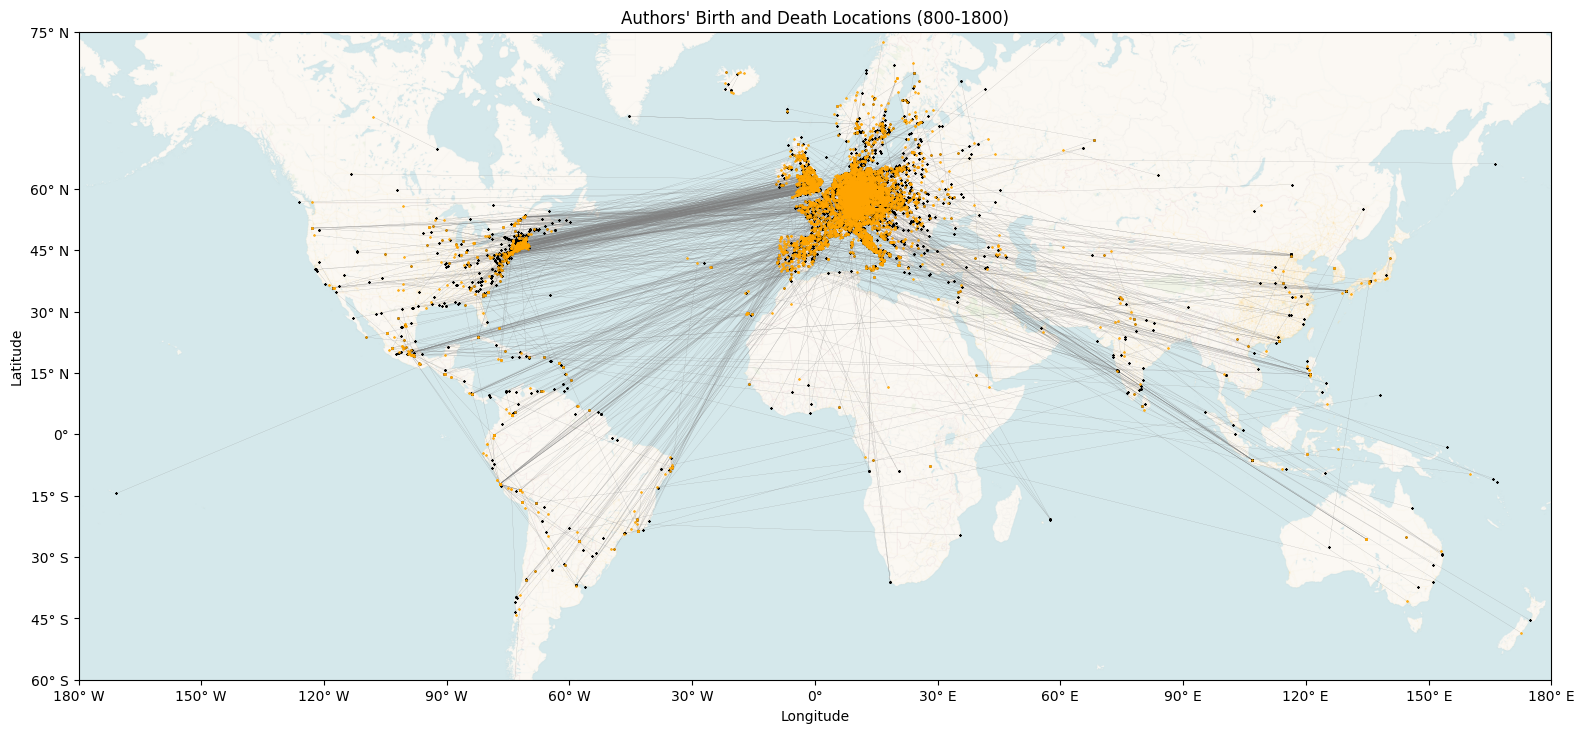

In [ ]:
## Straight line connecting birth and death locations

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import contextily as cx
import os

# Assuming 'authors_small_cities_copy' is your GeoDataFrame and it's already loaded

# select only years between 800 and 1800
authors_small_cities_copy = authors_small_cities_copy[(authors_small_cities_copy['deathyear'] >= 800) & (authors_small_cities_copy['deathyear'] <= 1800)]

# Drop rows where the birth or death latitude/longitude is NaN
authors_small_cities_copy = authors_small_cities_copy.dropna(subset=['latitude_born', 'longitude_born', 'latitude_death', 'longitude_death'])

# Create Points for birth and death locations
authors_small_cities_copy['birth_point'] = authors_small_cities_copy.apply(lambda row: Point(row['longitude_born'], row['latitude_born']), axis=1)
authors_small_cities_copy['death_point'] = authors_small_cities_copy.apply(lambda row: Point(row['longitude_death'], row['latitude_death']), axis=1)

# Create a LineString between birth and death points
authors_small_cities_copy['line'] = authors_small_cities_copy.apply(lambda row: LineString([row['birth_point'], row['death_point']]), axis=1)

# Create GeoDataFrames for points and lines
birth_points_gdf = gpd.GeoDataFrame(authors_small_cities_copy, geometry='birth_point')
death_points_gdf = gpd.GeoDataFrame(authors_small_cities_copy, geometry='death_point')
lines_gdf = gpd.GeoDataFrame(authors_small_cities_copy, geometry='line')

# Ensure the GeoDataFrame uses the WGS84 coordinate reference system
birth_points_gdf.set_crs(epsg=4326, inplace=True)
death_points_gdf.set_crs(epsg=4326, inplace=True)
lines_gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator projection for plotting with basemap
birth_points_gdf = birth_points_gdf.to_crs(epsg=3857)
death_points_gdf = death_points_gdf.to_crs(epsg=3857)
lines_gdf = lines_gdf.to_crs(epsg=3857)

# World bounds for Czech Republic region (approximation)
world_bounds = [1345852.64, 6190443.81, 2170730.07, 6631028.36] # Czech Republic boundaries approximation

fig, ax = plt.subplots(figsize=(19, 10))

# Plot the birth points in blue
birth_points_gdf.plot(ax=ax, color='orange', alpha=0.8, markersize=1, marker="*", zorder=3, label='Birth Locations')

# Plot the death points in black
death_points_gdf.plot(ax=ax, color='black', markersize=1, marker="x", zorder=2, label='Death Locations')

# Plot the lines
lines_gdf.plot(ax=ax, color='grey', linewidth=0.1, zorder=1)

# Add basemap with fixed zoom level
cx.add_basemap(ax, attribution=False, zoom=5, crs=birth_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

# Set plot limits to fixed geographic bounds
ax.set_xlim(world_bounds[0], world_bounds[2])
ax.set_ylim(world_bounds[1], world_bounds[3])

# Set title and axis labels
ax.set_title("Authors' Birth and Death Locations (800-1800)")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set tick labels to show the Mercator projection coordinates
ax.set_xticks([-20037508.34, -16707925.61, -13358339.89, -10018754.17, -6679169.45, -3339584.72, 0, 3339584.72, 6679169.45, 10018754.17, 13358339.89, 16707925.61, 20037508.34])
ax.set_xticklabels(['180° W', '150° W', '120° W', '90° W', '60° W', '30° W', '0°', '30° E', '60° E', '90° E', '120° E', '150° E', '180° E'])

ax.set_yticks([-6679169, -5009377, -3339584, -1669792, 0, 1669792, 3339584, 5009377, 6679169, 10958014.95])
ax.set_yticklabels(["60° S", "45° S", '30° S', "15° S", '0°', "15° N", '30° N', "45° N", "60° N", "75° N"])

# Save plot as .png file
output_dir = "/content/drive/My Drive/capita_selecta/active_maps/"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/born_death.png")

# Close the current figure to avoid overlapping plots
plt.show()











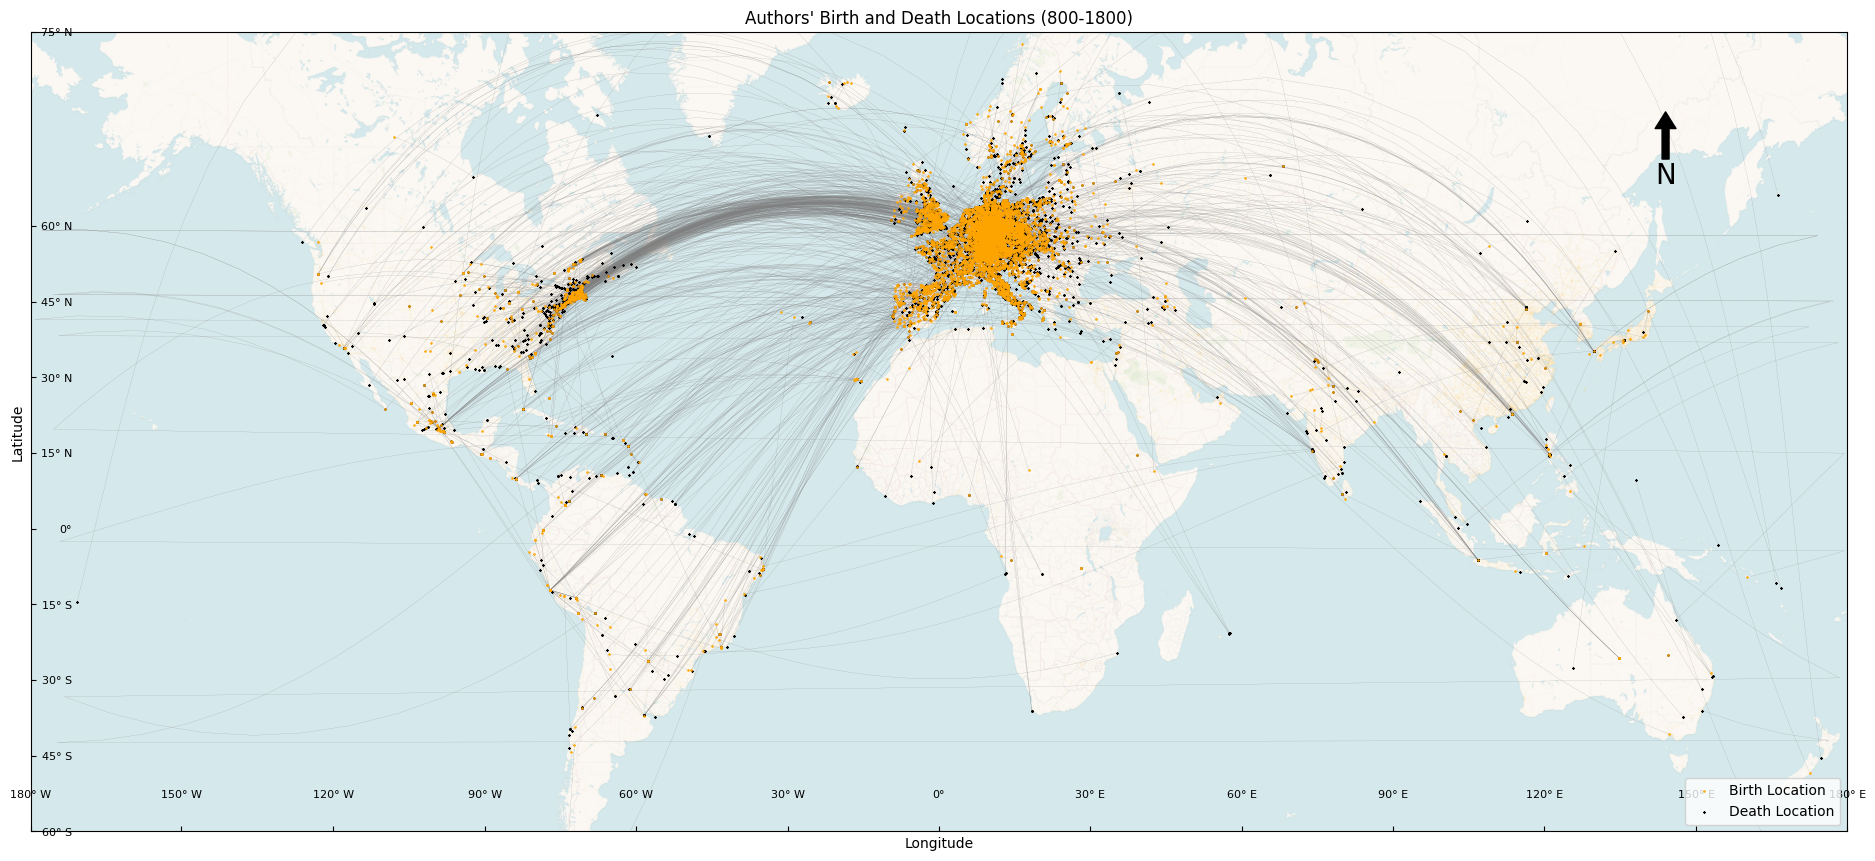

In [ ]:
###  curved lines connecting birth and death location, legend and north arrow included

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import contextily as cx
import os
from pyproj import Geod
import numpy as np # import numpy

# Assuming 'authors_small_cities_copy' is your GeoDataFrame and it's already loaded

# Select only years between 800 and 1800
authors_small_cities_copy = authors_small_cities_copy[(authors_small_cities_copy['deathyear'] >= 800) & (authors_small_cities_copy['deathyear'] <= 1800)]

# Drop rows where the birth or death latitude/longitude is NaN
authors_small_cities_copy = authors_small_cities_copy.dropna(subset=['latitude_born', 'longitude_born', 'latitude_death', 'longitude_death'])

# Create Points for birth and death locations
authors_small_cities_copy['birth_point'] = authors_small_cities_copy.apply(lambda row: Point(row['longitude_born'], row['latitude_born']), axis=1)
authors_small_cities_copy['death_point'] = authors_small_cities_copy.apply(lambda row: Point(row['longitude_death'], row['latitude_death']), axis=1)

# Create geodesic lines between birth and death points
def create_geodesic_line(row):
    geod = Geod(ellps="WGS84")
    lon1, lat1 = row['longitude_born'], row['latitude_born']
    lon2, lat2 = row['longitude_death'], row['latitude_death']
    # Use inv method to calculate geodesic line
    points = geod.npts(lon1, lat1, lon2, lat2, 20) # use npts to get intermediate points
    # Create a LineString from the calculated points
    return LineString([(lon1, lat1)] + points + [(lon2, lat2)])

authors_small_cities_copy['line'] = authors_small_cities_copy.apply(create_geodesic_line, axis=1)

# Create GeoDataFrames for points and lines
birth_points_gdf = gpd.GeoDataFrame(authors_small_cities_copy, geometry='birth_point')
death_points_gdf = gpd.GeoDataFrame(authors_small_cities_copy, geometry='death_point')
lines_gdf = gpd.GeoDataFrame(authors_small_cities_copy, geometry='line')

# Ensure the GeoDataFrame uses the WGS84 coordinate reference system
birth_points_gdf.set_crs(epsg=4326, inplace=True)
death_points_gdf.set_crs(epsg=4326, inplace=True)
lines_gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator projection for plotting with basemap
birth_points_gdf = birth_points_gdf.to_crs(epsg=3857)
death_points_gdf = death_points_gdf.to_crs(epsg=3857)
lines_gdf = lines_gdf.to_crs(epsg=3857)

# World bounds for Czech Republic region (approximation)
world_bounds = [1345852.64, 6190443.81, 2170730.07, 6631028.36] # Czech Republic boundaries approximation

fig, ax = plt.subplots(figsize=(19, 10))



# Plot the birth points in blue
birth_points_gdf.plot(ax=ax, color='orange', alpha=0.8, markersize=1, marker="*", zorder=3, label='Birth Locations')

# Plot the death points in black
death_points_gdf.plot(ax=ax, color='black', markersize=1, marker="x", zorder=2, label='Death Locations')

# Plot the lines
lines_gdf.plot(ax=ax, color='grey', linewidth=0.1, zorder=1)

# Add basemap with fixed zoom level
cx.add_basemap(ax, attribution=False, zoom=5, crs=birth_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)
fig.tight_layout(pad=3)
ax.tick_params(direction="in")

#add legend
plt.legend(['Birth Location', 'Death Location'], loc="lower left")

#North arrow source: https://stackoverflow.com/questions/58088841/how-to-add-a-north-arrow-on-a-geopandas-map

x, y, arrow_length = 0.9, 0.9, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# Set plot limits to fixed geographic bounds
ax.set_xlim(world_bounds[0], world_bounds[2])
ax.set_ylim(world_bounds[1], world_bounds[3])


# Set title and axis labels

ax.set_title("Authors' Birth and Death Locations (800-1800)")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


# Set tick labels to show the Mercator projection coordinates
ax.set_xticks([-20037508.34, -16707925.61, -13358339.89, -10018754.17, -6679169.45, -3339584.72, 0, 3339584.72, 6679169.45, 10018754.17, 13358339.89, 16707925.61, 20037508.34])
ax.set_xticklabels(['180° W', '150° W', '120° W', '90° W', '60° W', '30° W', '0°', '30° E', '60° E', '90° E', '120° E', '150° E', '180° E'])

ax.set_yticks([-6679169, -5009377, -3339584, -1669792, 0, 1669792, 3339584, 5009377, 6679169, 10958014.95])
ax.set_yticklabels(["", "45° S", '30° S', "15° S", '0°', "15° N", '30° N', "45° N", "60° N", ""])

# Adjust position of tick labels
ax.tick_params(axis='x', pad=-30, labelsize=8)
ax.tick_params(axis='y', pad=-30, labelsize=8)

# Save plot as .png file
output_dir = "/content/drive/My Drive/capita_selecta/active_maps/"   # Update this path accordingly
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/authors_birth_death_world_curv_800-1800.png")

# Close the current figure to avoid overlapping plots
plt.show()


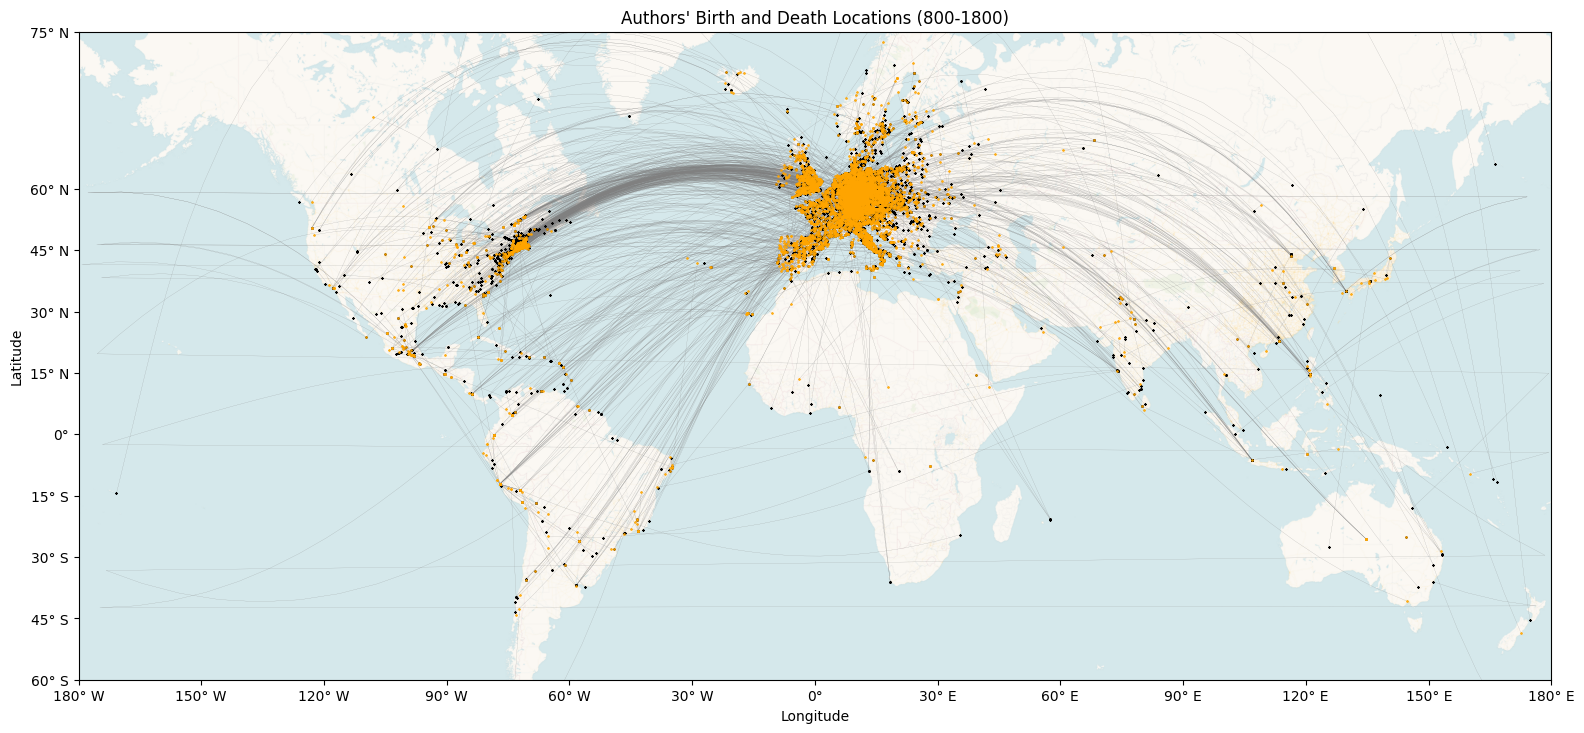

In [ ]:
## curved without lambda:

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import contextily as cx
import os
from pyproj import Geod
import numpy as np

# Assuming 'authors_small_cities_copy' is your GeoDataFrame and it's already loaded

# Select only years between 800 and 1800
authors_small_cities_copy = authors_small_cities_copy[(authors_small_cities_copy['deathyear'] >= 800) & (authors_small_cities_copy['deathyear'] <= 1800)]

# Drop rows where the birth or death latitude/longitude is NaN
authors_small_cities_copy = authors_small_cities_copy.dropna(subset=['latitude_born', 'longitude_born', 'latitude_death', 'longitude_death'])

# Create Points for birth and death locations
authors_small_cities_copy['birth_point'] = [Point(xy) for xy in zip(authors_small_cities_copy['longitude_born'], authors_small_cities_copy['latitude_born'])]
authors_small_cities_copy['death_point'] = [Point(xy) for xy in zip(authors_small_cities_copy['longitude_death'], authors_small_cities_copy['latitude_death'])]

# Create geodesic lines between birth and death points
def create_geodesic_line(lon1, lat1, lon2, lat2):
    geod = Geod(ellps="WGS84")
    points = geod.npts(lon1, lat1, lon2, lat2, 20) # use npts to get intermediate points
    return LineString([(lon1, lat1)] + points + [(lon2, lat2)])

authors_small_cities_copy['line'] = [create_geodesic_line(lon1, lat1, lon2, lat2) for lon1, lat1, lon2, lat2 in zip(authors_small_cities_copy['longitude_born'], authors_small_cities_copy['latitude_born'], authors_small_cities_copy['longitude_death'], authors_small_cities_copy['latitude_death'])]

# Create GeoDataFrames for points and lines
birth_points_gdf = gpd.GeoDataFrame(authors_small_cities_copy, geometry='birth_point')
death_points_gdf = gpd.GeoDataFrame(authors_small_cities_copy, geometry='death_point')
lines_gdf = gpd.GeoDataFrame(authors_small_cities_copy, geometry='line')

# Ensure the GeoDataFrame uses the WGS84 coordinate reference system
birth_points_gdf.set_crs(epsg=4326, inplace=True)
death_points_gdf.set_crs(epsg=4326, inplace=True)
lines_gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator projection for plotting with basemap
birth_points_gdf = birth_points_gdf.to_crs(epsg=3857)
death_points_gdf = death_points_gdf.to_crs(epsg=3857)
lines_gdf = lines_gdf.to_crs(epsg=3857)

# World bounds for Czech Republic region (approximation)
world_bounds = [1345852.64, 6190443.81, 2170730.07, 6631028.36] # Czech Republic boundaries approximation

fig, ax = plt.subplots(figsize=(19, 10))

# Plot the birth points in blue
birth_points_gdf.plot(ax=ax, color='orange', alpha=0.8, markersize=1, marker="*", zorder=3, label='Birth Locations')

# Plot the death points in black
death_points_gdf.plot(ax=ax, color='black', markersize=1, marker="x", zorder=2, label='Death Locations')

# Plot the lines
lines_gdf.plot(ax=ax, color='grey', linewidth=0.1, zorder=1)

# Add basemap with fixed zoom level
cx.add_basemap(ax, attribution=False, zoom=5, crs=birth_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

# Set plot limits to fixed geographic bounds
ax.set_xlim(world_bounds[0], world_bounds[2])
ax.set_ylim(world_bounds[1], world_bounds[3])

# Set title and axis labels
# plt.rcParams["font.serif"] = "Times New Roman"

ax.set_title("Authors' Birth and Death Locations (800-1800)")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set tick labels to show the Mercator projection coordinates
ax.set_xticks([-20037508.34, -16707925.61, -13358339.89, -10018754.17, -6679169.45, -3339584.72, 0, 3339584.72, 6679169.45, 10018754.17, 13358339.89, 16707925.61, 20037508.34])
ax.set_xticklabels(['180° W', '150° W', '120° W', '90° W', '60° W', '30° W', '0°', '30° E', '60° E', '90° E', '120° E', '150° E', '180° E'])

ax.set_yticks([-6679169, -5009377, -3339584, -1669792, 0, 1669792, 3339584, 5009377, 6679169, 10958014.95])
ax.set_yticklabels(["60° S", "45° S", '30° S', "15° S", '0°', "15° N", '30° N', "45° N", "60° N", "75° N"])

# Save plot as .png file
output_dir = "output_directory_path_here"  # Update this path accordingly
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/authors_birth_death_world_curved_800-1800.png")

# Close the current figure to avoid overlapping plots
plt.show()


## ONLY EUROPE

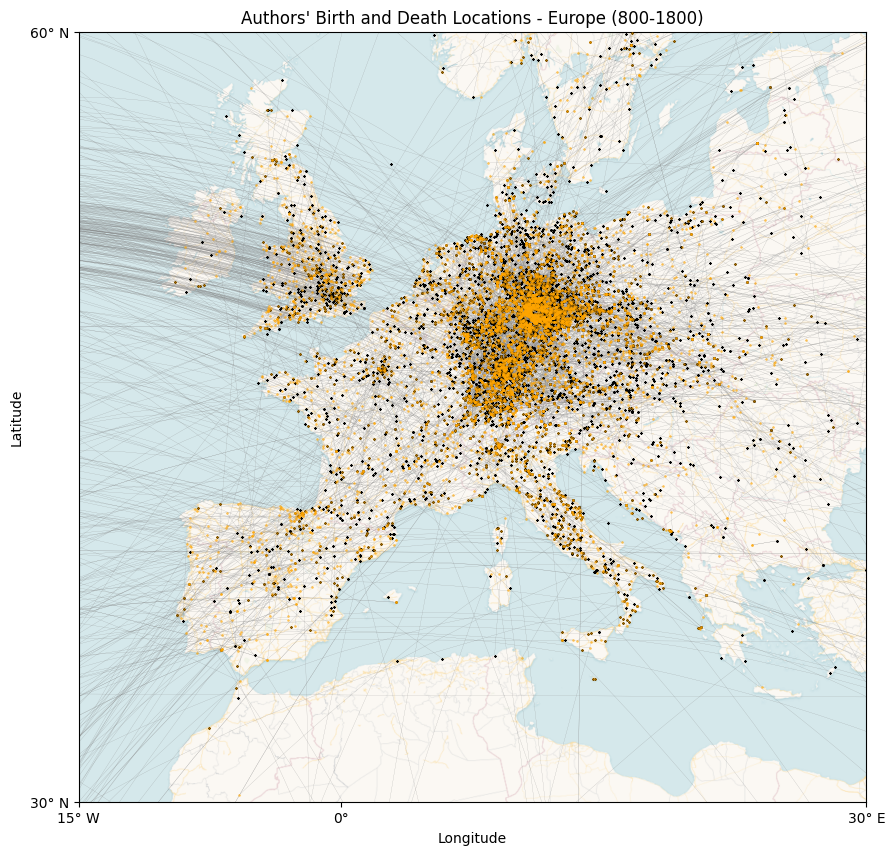

In [ ]:
#### ONLY EUROPE



# World bounds for Czech Republic region (approximation)
world_bounds = [1345852.64, 6190443.81, 2170730.07, 6631028.36] # Czech Republic boundaries approximation

fig, ax = plt.subplots(figsize=(19, 10))

# Plot the birth points in blue
birth_points_gdf.plot(ax=ax, color='orange', alpha=0.5, markersize=1, marker="*", zorder=3, label='Birth Locations')

# Plot the death points in black
death_points_gdf.plot(ax=ax, color='black', alpha=1, markersize=1, marker="x", zorder=2, label='Death Locations')

# Plot the lines
lines_gdf.plot(ax=ax, color='grey', linewidth=0.1, zorder=1)

# Add basemap with fixed zoom level
cx.add_basemap(ax, attribution=False, zoom=5, crs=birth_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

# Set plot limits to fixed geographic bounds
ax.set_xlim(world_bounds[0], world_bounds[2])
ax.set_ylim(world_bounds[1], world_bounds[3])

# Set title and axis labels
ax.set_title("Authors' Birth and Death Locations - Europe (800-1800)")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set tick labels to show the Mercator projection coordinates

ax.set_xticks([ -1669792, 0, 3339584.72])
ax.set_xticklabels(['15° W', '0°', '30° E'])

ax.set_yticks([ 3503549.84, 8399737.88])
ax.set_yticklabels(['30° N', "60° N"])



# Save plot as .png file
output_dir = "output_directory_path_here"  # Update this path accordingly
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/authors_birth_death_europe_curved_800-1800.png")

# Close the current figure to avoid overlapping plots
plt.show()



I need to add legend and north arrow in the map below

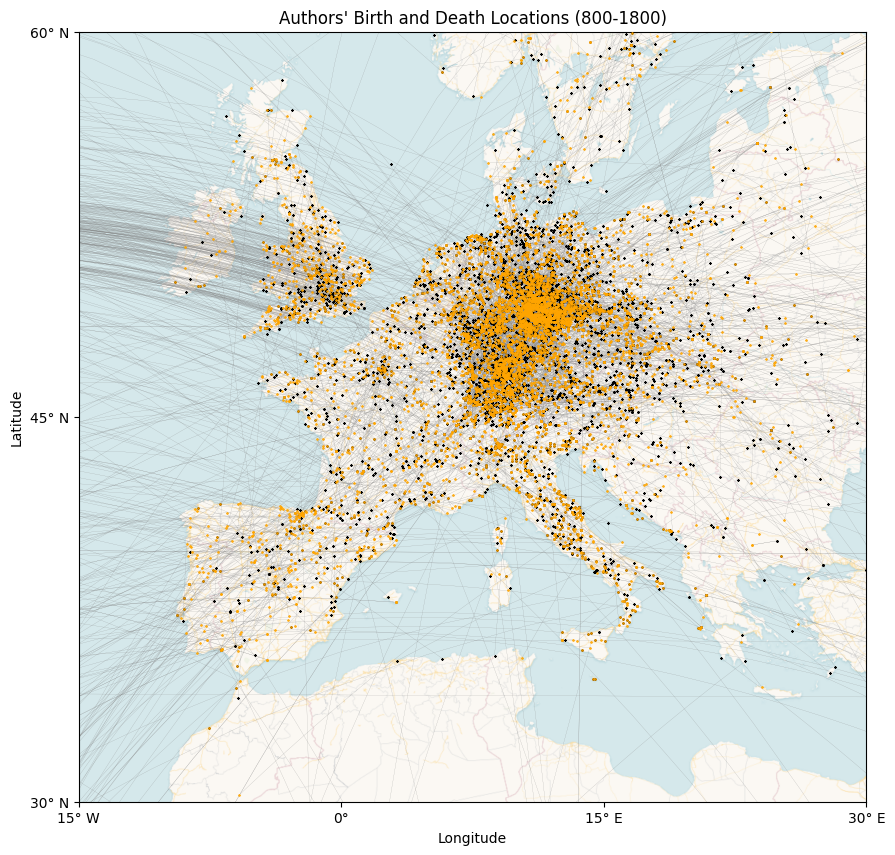

In [ ]:
###  curved lines Europe

# import geopandas as gpd
# import matplotlib.pyplot as plt
# from shapely.geometry import Point, LineString
# import contextily as cx
# import os
# from pyproj import Geod
# import numpy as np # import numpy

# # Assuming 'authors_small_cities_copy' is your GeoDataFrame and it's already loaded

# # Select only years between 800 and 1800
# authors_small_cities_copy = authors_small_cities_copy[(authors_small_cities_copy['deathyear'] >= 800) & (authors_small_cities_copy['deathyear'] <= 1800)]

# # Drop rows where the birth or death latitude/longitude is NaN
# authors_small_cities_copy = authors_small_cities_copy.dropna(subset=['latitude_born', 'longitude_born', 'latitude_death', 'longitude_death'])

# # Create Points for birth and death locations
# authors_small_cities_copy['birth_point'] = authors_small_cities_copy.apply(lambda row: Point(row['longitude_born'], row['latitude_born']), axis=1)
# authors_small_cities_copy['death_point'] = authors_small_cities_copy.apply(lambda row: Point(row['longitude_death'], row['latitude_death']), axis=1)

# # Create geodesic lines between birth and death points
# def create_geodesic_line(row):
#     geod = Geod(ellps="WGS84")
#     lon1, lat1 = row['longitude_born'], row['latitude_born']
#     lon2, lat2 = row['longitude_death'], row['latitude_death']
#     # Use inv method to calculate geodesic line
#     points = geod.npts(lon1, lat1, lon2, lat2, 20) # use npts to get intermediate points
#     # Create a LineString from the calculated points
#     return LineString([(lon1, lat1)] + points + [(lon2, lat2)])

# authors_small_cities_copy['line'] = authors_small_cities_copy.apply(create_geodesic_line, axis=1)

# # Create GeoDataFrames for points and lines
# birth_points_gdf = gpd.GeoDataFrame(authors_small_cities_copy, geometry='birth_point')
# death_points_gdf = gpd.GeoDataFrame(authors_small_cities_copy, geometry='death_point')
# lines_gdf = gpd.GeoDataFrame(authors_small_cities_copy, geometry='line')

# # Ensure the GeoDataFrame uses the WGS84 coordinate reference system
# birth_points_gdf.set_crs(epsg=4326, inplace=True)
# death_points_gdf.set_crs(epsg=4326, inplace=True)
# lines_gdf.set_crs(epsg=4326, inplace=True)

# # Convert to Web Mercator projection for plotting with basemap
# birth_points_gdf = birth_points_gdf.to_crs(epsg=3857)
# death_points_gdf = death_points_gdf.to_crs(epsg=3857)
# lines_gdf = lines_gdf.to_crs(epsg=3857)

# bounds for Czech Republic region (approximation)
world_bounds = [1345852.64, 6190443.81, 2170730.07, 6631028.36] # Czech Republic boundaries approximation

fig, ax = plt.subplots(figsize=(19, 10))

# Plot the birth points in blue
birth_points_gdf.plot(ax=ax, color='orange', alpha=0.8, markersize=1, marker="*", zorder=3, label='Birth Locations')

# Plot the death points in black
death_points_gdf.plot(ax=ax, color='black', markersize=1, marker="x", zorder=2, label='Death Locations')

# Plot the lines
lines_gdf.plot(ax=ax, color='grey', linewidth=0.1, zorder=1)

# Add basemap with fixed zoom level
cx.add_basemap(ax, attribution=False, zoom=5, crs=birth_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

# Set plot limits to fixed geographic bounds
ax.set_xlim(world_bounds[0], world_bounds[2])
ax.set_ylim(world_bounds[1], world_bounds[3])

# Set title and axis labels

# plt.rcParams["font.serif"] = "Times New Roman"

ax.set_title("Authors' Birth and Death Locations (800-1800)")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


# Set tick labels to show the Mercator projection coordinates
ax.set_xticks([ -1669792, 0, 1669792, 3339584.72])
ax.set_xticklabels(['15° W', '0°', '15° E', '30° E'])

ax.set_yticks([ 3503549.84, 5951550.36, 8399550.88])
ax.set_yticklabels(['30° N', '45° N', "60° N"])

# Save plot as .png file
output_dir = "output_directory_path_here"  # Update this path accordingly
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/born_death.png")

# Close the current figure to avoid overlapping plots
plt.show()
